# AI4NE Project: Wildifire Classification
## Maksims Habirovs

### Importing libraries and frameworks

In [31]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from PIL import Image
from google.colab import drive

### Preparing the Data

In [32]:
# Create data generators
def data_generator(files, batch_size):
    while True:
        random.shuffle(files)
        for i in range(0, len(files), batch_size):
            batch_files = files[i:i + batch_size]
            batch_images = [load_img(file, target_size=(img_width, img_height)) for file in batch_files]
            batch_images = [img_to_array(img) / 255.0 for img in batch_images]  # Normalize the images
            batch_labels = [0 if "non_fire" in file else 1 for file in batch_files]  # Assign labels
            yield np.array(batch_images), np.array(batch_labels)

# Mount Google Drive
drive.mount('/content/drive')

# Set the paths to dataset directory
fire_dir = "/content/drive/MyDrive/AI4NE/fire_dataset/fire_images"
no_fire_dir = "/content/drive/MyDrive/AI4NE/fire_dataset/non_fire_images"

# List all the image files
fire_images = [os.path.join(fire_dir, filename) for filename in os.listdir(fire_dir) if filename.endswith('.png')]
no_fire_images = [os.path.join(no_fire_dir, filename) for filename in os.listdir(no_fire_dir) if filename.endswith('.png')]

# Split the data into train, validation, and test sets
train_fire, temp_fire = train_test_split(fire_images, test_size=0.3, random_state=42)
validation_fire, test_fire = train_test_split(temp_fire, test_size=0.5, random_state=42)

train_no_fire, temp_no_fire = train_test_split(no_fire_images, test_size=0.3, random_state=42)
validation_no_fire, test_no_fire = train_test_split(temp_no_fire, test_size=0.5, random_state=42)

# List train, validation, and test file paths
train_files = train_fire + train_no_fire
validation_files = validation_fire + validation_no_fire
test_files = test_fire + test_no_fire

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Displaying the images

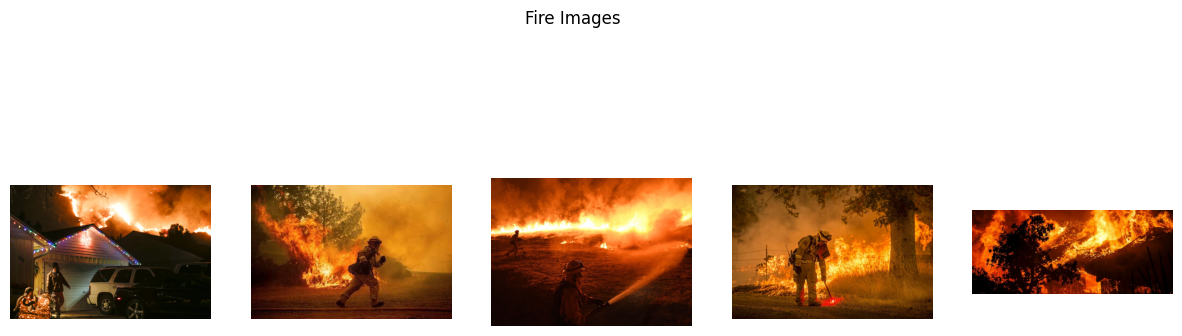

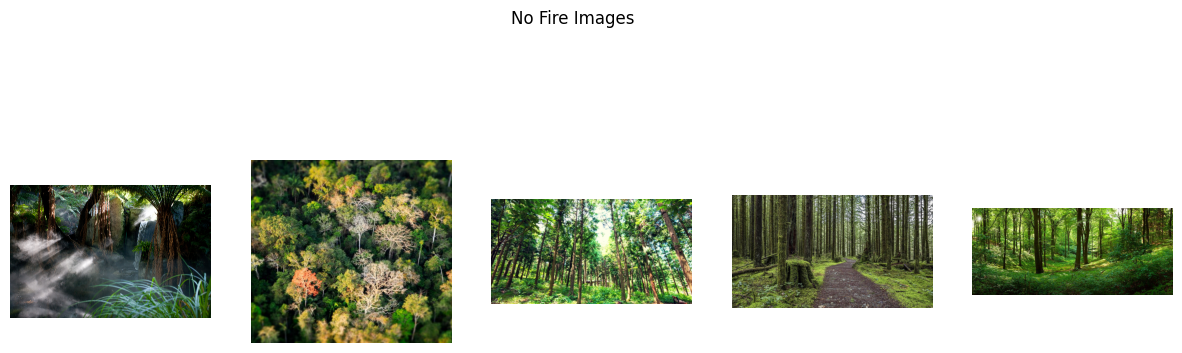

In [33]:
# List a few random images from each category
num_images_to_display = 5
fire_images = [os.path.join(fire_dir, filename) for filename in random.sample(os.listdir(fire_dir), num_images_to_display)]
no_fire_images = [os.path.join(no_fire_dir, filename) for filename in random.sample(os.listdir(no_fire_dir), num_images_to_display)]

# Function to display images
def display_images(image_paths, title):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))
    fig.suptitle(title)
    for i, image_path in enumerate(image_paths):
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')
    plt.show()

# Display fire images
display_images(fire_images, title="Fire Images")
display_images(no_fire_images, title="No Fire Images")

### Setting up and compiling the VGG16 CNN Model

In [34]:
from tensorflow.keras.applications import VGG16

# Parameters for VGG16 model
img_width, img_height = 224, 224
batch_size = 32
epochs = 20

# Creating a VGG16 base model with pre-trained weights and without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the convolutional layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add custom classification layers on top of the base model
vggmodel = Sequential()
vggmodel.add(base_model)
vggmodel.add(Flatten())
vggmodel.add(Dense(256, activation='relu'))
vggmodel.add(Dropout(0.5))
vggmodel.add(Dense(1, activation='sigmoid'))

# Compile the model
vggmodel.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy', 'Precision', 'Recall'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=3, monitor='val_loss')

# Train the model
train_steps = len(train_files) // batch_size
validation_steps = len(validation_files) // batch_size

vggmodel.fit(data_generator(train_files, batch_size),
          steps_per_epoch=train_steps,
          epochs=epochs,
          validation_data=data_generator(validation_files, batch_size),
          validation_steps=validation_steps,
          callbacks=[early_stopping])

# Evaluate the model on the test set
test_steps = len(test_files) // batch_size
test_loss, test_accuracy, test_precision, test_recall = vggmodel.evaluate(data_generator(test_files, batch_size), steps=test_steps)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}, Test Recall: {test_recall}")

Epoch 1/20
21/21 [==============================] - 78s 864ms/step - loss: 0.5637 - accuracy: 0.7604 - precision: 0.8112 - recall: 0.8895 - val_loss: 0.3207 - val_accuracy: 0.8281 - val_precision: 0.8151 - val_recall: 1.0000
Epoch 2/20
21/21 [==============================] - 16s 796ms/step - loss: 0.2797 - accuracy: 0.8784 - precision: 0.8976 - recall: 0.9488 - val_loss: 0.2171 - val_accuracy: 0.8984 - val_precision: 0.9495 - val_recall: 0.9216
Epoch 3/20
21/21 [==============================] - 15s 753ms/step - loss: 0.2239 - accuracy: 0.9054 - precision: 0.9253 - recall: 0.9527 - val_loss: 0.2179 - val_accuracy: 0.9219 - val_precision: 0.9773 - val_recall: 0.9149
Epoch 4/20
21/21 [==============================] - 17s 838ms/step - loss: 0.1768 - accuracy: 0.9339 - precision: 0.9481 - recall: 0.9635 - val_loss: 0.2076 - val_accuracy: 0.9297 - val_precision: 0.9775 - val_recall: 0.9255
Epoch 5/20
21/21 [==============================] - 19s 965ms/step - loss: 0.1300 - accuracy: 0.9580

### Making predictions and inspecting them

In [35]:
# Function to preprocess and make predictions with actual labels using random images
def predict_random_images_with_labels(image_paths, model):
    num_images_to_display = min(len(image_paths), 10)
    random_images = random.sample(image_paths, num_images_to_display)
    rows = (num_images_to_display + 4) // 5  # Calculate the number of rows needed (5 images per row)

    fig, axes = plt.subplots(rows, 5, figsize=(15, 3 * rows))
    fig.suptitle("Actual Labels and Model Predictions", fontsize=16)

    for i in range(num_images_to_display):
        image_path = random_images[i]
        image = Image.open(image_path)
        image = image.resize((img_width, img_height))  # Resize to match model input size
        image = np.array(image) / 255.0  # Normalize
        image = np.expand_dims(image, axis=0)  # Add batch dimension
        prediction = model.predict(image)

        if prediction[0] >= 0.5:
            result = "Fire"
        else:
            result = "No Fire"

        actual_label = "No Fire" if "non_fire" in image_path else "Fire"

        row = i // 5
        col = i % 5
        axes[row, col].imshow(Image.open(image_path))
        axes[row, col].set_title(f"Actual: {actual_label}\nPrediction: {result}")
        axes[row, col].axis('off')

    # Hide any remaining empty subplots
    for i in range(num_images_to_display, rows * 5):
        row = i // 5
        col = i % 5
        fig.delaxes(axes[row, col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

1/1 [==============================] - 0s 19ms/step


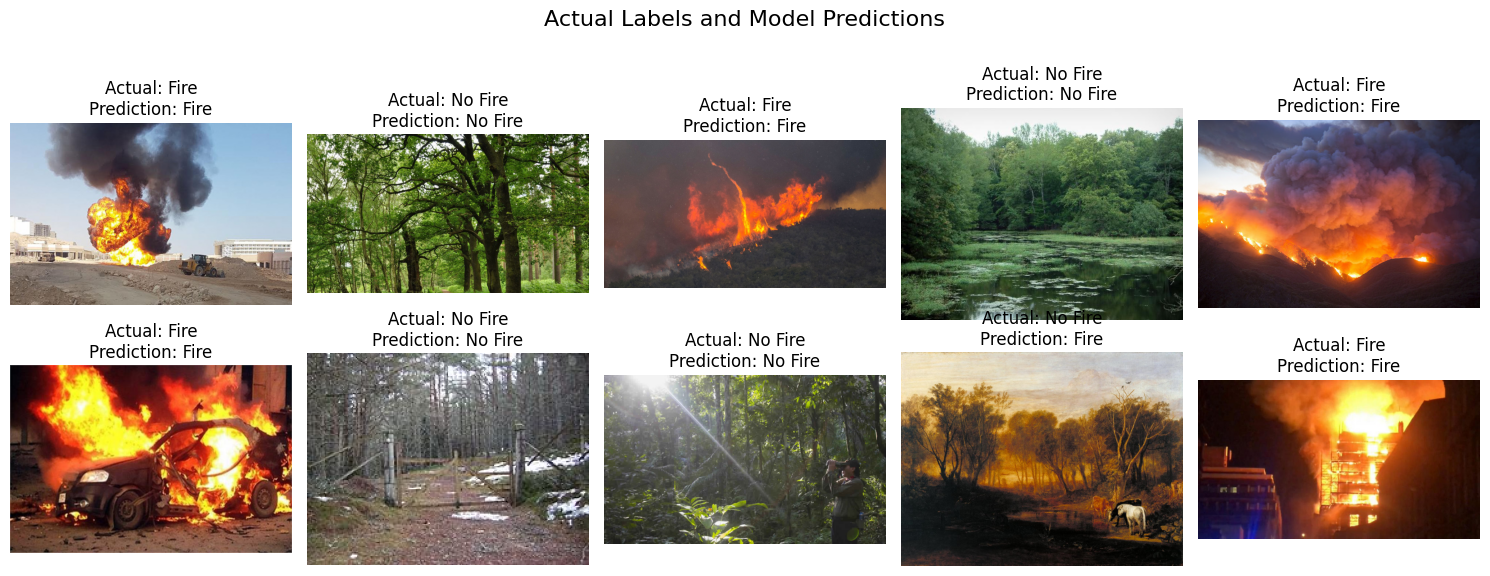

In [53]:
# Make predictions and display random images with labels and predictions (up to 10 random images)
predict_random_images_with_labels(test_files, vggmodel)

### Setting up and compiling the custom CNN

In [41]:
# Parameters for CNN
img_width, img_height = 250, 250
input_shape = (img_width, img_height, 3)
epochs = 20
batch_size = 32

# Initialize CNN
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5)) # Dropout layer to reduce overfitting
model.add(Dense(1))
model.add(Activation('sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy', 'Precision', 'Recall'])

### Training the Custom CNN

In [43]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=3, monitor='val_loss')

# Train the model
train_steps = len(train_files) // batch_size
validation_steps = len(validation_files) // batch_size

model.fit(data_generator(train_files, batch_size),
          steps_per_epoch=train_steps,
          epochs=epochs,
          validation_data=data_generator(validation_files, batch_size),
          validation_steps=validation_steps,
          callbacks=[early_stopping])

# Evaluate the model on the test set
test_steps = len(test_files) // batch_size
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(data_generator(test_files, batch_size), steps=test_steps)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}, Test Recall: {test_recall}")

Epoch 1/20
21/21 [==============================] - 17s 837ms/step - loss: 0.1364 - accuracy: 0.9420 - precision: 0.9533 - recall: 0.9703 - val_loss: 0.1783 - val_accuracy: 0.9219 - val_precision: 1.0000 - val_recall: 0.8969
Epoch 2/20
21/21 [==============================] - 16s 806ms/step - loss: 0.0804 - accuracy: 0.9685 - precision: 0.9750 - recall: 0.9844 - val_loss: 0.0870 - val_accuracy: 0.9844 - val_precision: 0.9897 - val_recall: 0.9897
Epoch 3/20
21/21 [==============================] - 16s 797ms/step - loss: 0.0943 - accuracy: 0.9730 - precision: 0.9780 - recall: 0.9859 - val_loss: 0.1141 - val_accuracy: 0.9453 - val_precision: 0.9892 - val_recall: 0.9388
Epoch 4/20
21/21 [==============================] - 19s 937ms/step - loss: 0.0601 - accuracy: 0.9865 - precision: 0.9862 - recall: 0.9960 - val_loss: 0.0891 - val_accuracy: 0.9609 - val_precision: 0.9794 - val_recall: 0.9694
Epoch 5/20
4/4 [==============================] - 3s 879ms/step - loss: 0.1489 - accuracy: 0.9297 - 

1/1 [==============================] - 0s 19ms/step


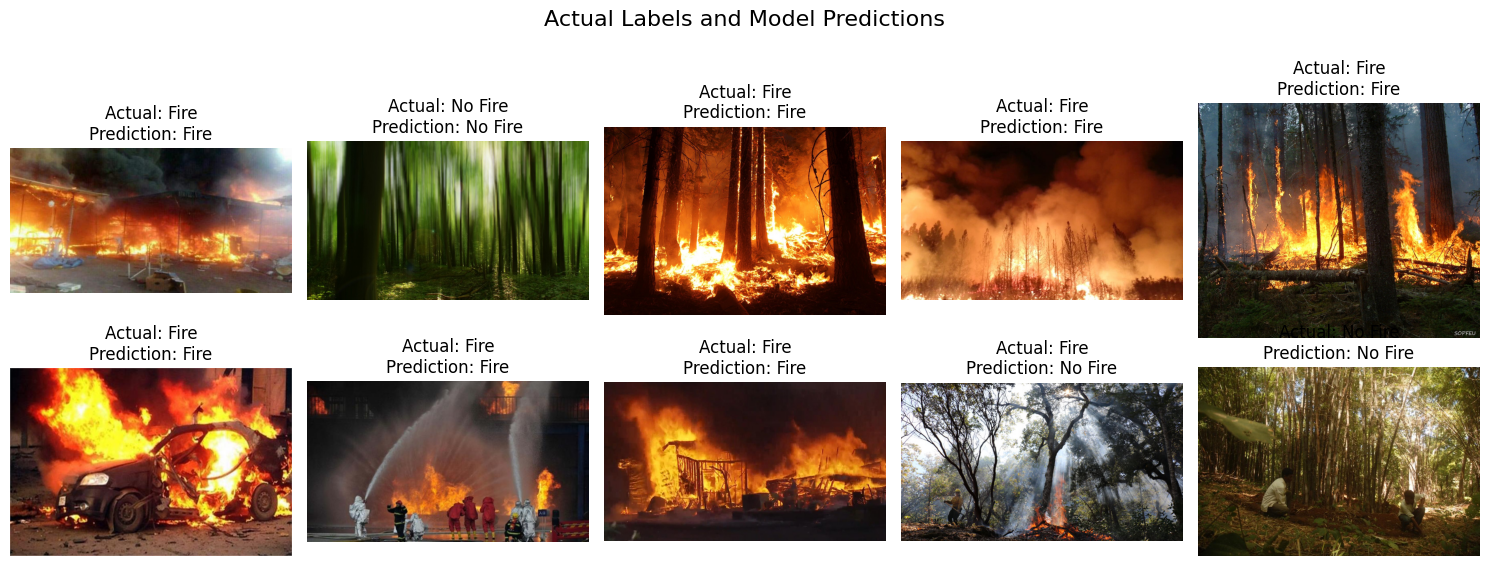

In [46]:
# Make predictions and display random images with labels and predictions (up to 10 random images)
predict_random_images_with_labels(test_files, model)